# Sparse Spiking Ensemble

- Ensemble = Sensory neurons + latent neurons
- Sensory neurons get spikes from sensory inputs
- Sensory inputs are sparse coded (~20% 1s, rest 0s)
- Each neuron also takes input from the whole ensemble (later to be restricted locally)


self.activation after decay tensor([0., 0., 0., 0., 0., 0., 0.])
self.activation tensor([0.6046, 0.5830, 0.5919, 0.5838, 0.5802, 0.0000, 0.0000])
self.activation tensor([-0.2000, -0.2000, -0.2000, -0.2000, -0.2000,  0.0000,  0.0000])
self.activation after decay tensor([-0.1980, -0.1980, -0.1980, -0.1980, -0.1980,  0.0000,  0.0000])
self.activation tensor([0.4068, 0.3852, 0.3941, 0.3860, 0.3824, 0.0000, 0.0000])
self.activation tensor([1., 1., 1., 1., 1., 0., 0.])
self.activation after decay tensor([0.9900, 0.9900, 0.9900, 0.9900, 0.9900, 0.0000, 0.0000])
self.activation tensor([1.7002, 1.6911, 1.2860, 1.7231, 1.2158, 0.0000, 0.0000])
self.activation tensor([0.9900, 0.9900, 0.9900, 0.9900, 0.9900, 0.0000, 0.0000])
self.activation after decay tensor([0.9801, 0.9801, 0.9801, 0.9801, 0.9801, 0.0000, 0.0000])
self.activation tensor([1.6903, 1.6812, 1.2761, 1.7132, 1.2060, 0.0000, 0.0000])
self.activation tensor([0.9801, 0.9801, 0.9801, 0.9801, 0.9801, 0.0000, 0.0000])
self.activation after 

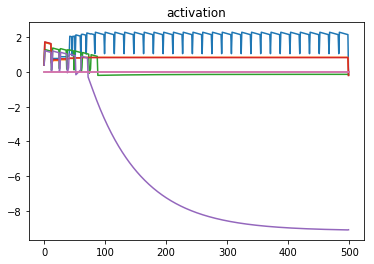

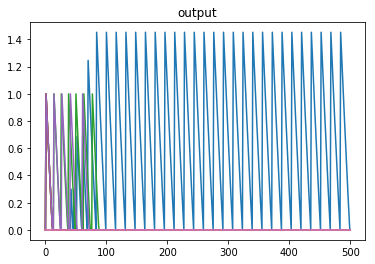

In [18]:
from collections import defaultdict
import torch
import matplotlib.pyplot as plt

SENSORY_MODALITY_1_SIZE = 10000

SENSORY_MODALITY_1_NEURONS = 5
LATENT_NEURONS = 2

SPARSITY = 0.2
NEGATIVE_WEIGHT = 0.2

ENSEMBLE_NEURONS = SENSORY_MODALITY_1_NEURONS + LATENT_NEURONS

def make_sparse_embedding(size):
  return (torch.FloatTensor(size).uniform_() < SPARSITY).long().float()

MODALITY_1_SYMBOLS = {
    'A': make_sparse_embedding(SENSORY_MODALITY_1_SIZE),
    'B': make_sparse_embedding(SENSORY_MODALITY_1_SIZE),
    'C': make_sparse_embedding(SENSORY_MODALITY_1_SIZE),
    'D': make_sparse_embedding(SENSORY_MODALITY_1_SIZE),
    'E': make_sparse_embedding(SENSORY_MODALITY_1_SIZE),
}

V_MAX = 1.0
V_UPPER_THRESHOLD = 0.9
V_MID = 0.5
V_LOWER_THRESHOLD = 0.1
V_ZERO = 0
V_RESET = -0.2

class Network:
  def __init__(self):
    self.activation = torch.zeros(ENSEMBLE_NEURONS)
    self.output = torch.zeros(ENSEMBLE_NEURONS)

    self.afferent_weights = torch.zeros((SENSORY_MODALITY_1_NEURONS, SENSORY_MODALITY_1_SIZE)).uniform_() - NEGATIVE_WEIGHT  # weights [-NEGATIVE_WEIGHT, 1-NEGATIVE_WEIGHT], e.g. [-0.2, 0.8]
    self.lateral_weights  = torch.zeros((ENSEMBLE_NEURONS, ENSEMBLE_NEURONS)).uniform_() - NEGATIVE_WEIGHT
    self.lateral_weights[torch.eye(ENSEMBLE_NEURONS).byte()] = 0

    self.afferent_trace = torch.zeros((SENSORY_MODALITY_1_SIZE,))
    self.lateral_trace = torch.zeros((ENSEMBLE_NEURONS,))
    self.learning_rate = 0.1
    self.lateral_inhibition = 1
    self.trace_alpha = 0.1
    self.activation_alpha = 0.001
    self.activiation_decay = 0.01
    self.history = defaultdict(lambda: [])
    self.captured_attributes = ['activation', 'output']

  def capture_history(self):
    for attr_name in self.captured_attributes:
      self.history[attr_name].append(getattr(self, attr_name))

  def report(self):
    for attr_name in self.captured_attributes:
      data = torch.stack(self.history[attr_name]).numpy()
      plt.plot(data)
      plt.title(attr_name)
      plt.show()

  def present_input(self, sensory_input):
    # Decay activation
    previous_active = self.activation > V_UPPER_THRESHOLD
    self.activation *= (1.0 - self.activiation_decay)
    print("self.activation after decay", self.activation)

    # Remember activation of currently active neurons
    # These should not accumulate input, only decay
    previous_active_activation = self.activation[previous_active]

    # Sensory inputs and trace
    weighted_input = self.afferent_weights * sensory_input
    self.afferent_trace = self.afferent_trace * (1 - self.trace_alpha) + sensory_input * self.trace_alpha   # NOTE: Trace of inputs before applying weights
    # print("weighted_input", weighted_input)
    # print("self.afferent_trace", self.afferent_trace)

    # Lateral inputs (i.e. previous output) and trace
    weighted_lateral_input = self.lateral_weights * self.output
    self.lateral_trace = self.lateral_trace * (1 - self.trace_alpha) + self.output * self.trace_alpha      # NOTE: Trace of lateral inputs before applying weights
    # print("weighted_lateral_input", weighted_lateral_input)
    # print("self.lateral_trace", self.lateral_trace)

    # Add inputs to activation
    self.activation[0:SENSORY_MODALITY_1_NEURONS] = self.activation[0:SENSORY_MODALITY_1_NEURONS] * (1 - self.activation_alpha) + weighted_input.sum(dim=1) * self.activation_alpha
    print("self.activation", self.activation)
    self.activation = self.activation * (1 - self.activation_alpha) + weighted_lateral_input.sum(dim=0) * self.activation_alpha
    # print("self.activation", self.activation)

    # Keep only decayed values for previously active 
    self.activation[previous_active] = previous_active_activation

    # Fire!
    need_to_activate = (self.activation > V_LOWER_THRESHOLD) & (self.activation < V_MID)
    self.activation[need_to_activate] = V_MAX
    # print("Firing", need_to_activate)

    # Reset!
    need_to_reset = (self.activation < V_UPPER_THRESHOLD) & (self.activation > V_MID)
    self.activation[need_to_reset] = V_RESET
    # print("Resetting", need_to_reset)

    # Currently active
    active = self.activation > V_UPPER_THRESHOLD
    self.output = torch.zeros(ENSEMBLE_NEURONS)
    self.output[active] = (self.activation[active] - V_UPPER_THRESHOLD) / (V_MAX - V_UPPER_THRESHOLD)
    # print("self.output", self.output)

    # print("self.afferent_weights", self.afferent_weights)
    # Learning
    fired_indices = need_to_activate.nonzero()
    if fired_indices.nelement() > 0:
      for i in fired_indices:
        fired_index = i.item()

        # afferent connections
        min_dist = 0.01
        dist_from_trace = self.afferent_weights - self.afferent_trace
        dw_afferent_self = self.learning_rate * dist_from_trace[fired_index]
        self.afferent_weights[fired_index] += dw_afferent_self

        # Lateral inhibition
        dist_from_trace[dist_from_trace.abs() < min_dist] = min_dist * dist_from_trace[dist_from_trace.abs() < min_dist].sign() # prep for division
        dw_afferent_neighbor = -self.learning_rate * self.lateral_inhibition * (1 / dist_from_trace) * (1 - self.afferent_weights[fired_index].abs())
        self.afferent_weights += dw_afferent_neighbor

    # Keep activation within bounds
    # torch.clamp(self.activation, V_RESET, V_MAX, out=self.activation)
    print("self.activation", self.activation)
    # self.activation[self.activation < V_RESET] = V_RESET
    # self.activation[self.activation > V_MAX] = V_MAX
    # print("self.activation clamped", self.activation)
    self.capture_history()

network = Network()
for i in range(500):
  network.present_input(MODALITY_1_SYMBOLS['A'])

network.report()


In [41]:
10234 +12305
100000000+1274776

101274776